In [1]:
import os
import glob
import pickle
import h5py

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import skimage.io as io
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

from caiman.source_extraction.volpy.spikepursuit import signal_filter

2023-09-16 12:43:45.014794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def smooth(x, axis=0, wid=5):
    # this is way faster than convolve
    if wid < 2:
        return x
    cumsum_vec = np.cumsum(np.insert(x, 0, 0, axis=axis), axis=axis)
    ma_vec = (cumsum_vec[wid:] - cumsum_vec[:-wid]) / wid
    y = x.copy()
    start_ind = int(np.floor((wid-1)/2))
    end_ind = wid-1-start_ind
    y[start_ind:-end_ind] = ma_vec
    return y

def flatten(x, wid):
    t = np.arange(x.shape[0])
    n_wid = np.ceil(x.shape[0]/wid).astype('int')
    xq = np.zeros(n_wid)
    tq = np.zeros(n_wid)
    for i in range(n_wid):
        tmp = x[(i*wid):((i+1)*wid-1)]
        lo = np.quantile(tmp, 0.3)
        hi = np.quantile(tmp, 0.8)
        tmp = tmp[tmp>lo]
        tmp = tmp[tmp<hi]
        xq[i] = tmp.mean()
        tq[i] = t[(i*wid):((i+1)*wid-1)].mean()
    y = np.interp(t, tq, xq)
    return y

def spike_SNR(t, spikes, fr=500):
    t = t - np.median(t)
    t_hp = signal_filter(t, 30, fr)
    selectSpikes = np.zeros(t.shape)
    selectSpikes[spikes] = 1
    sgn = np.mean(t[selectSpikes > 0])
    
    t_nonspike = np.zeros(t.shape)
    t_nonspike[spikes] = 1
    t_nonspike = np.convolve(t_nonspike, np.ones(20)/20, 'same') 
    t_nonspike = t_nonspike == 0 

    ff1 = -t_hp * (t_hp < 0) * t_nonspike
    ff1 = ff1[ff1 < np.quantile(ff1, 0.995)]
    Ns = np.sum(ff1 > 0)
    noise = np.sqrt(np.divide(np.sum(ff1**2), Ns)) 
    return sgn / noise


In [3]:
def AP_ticks(ax, ap_loc, tick_level=1.0, tick_height=0.1, linewidth=0.5, color='r'):
    # ref: https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib
    n = len(ap_loc)
    a = np.c_[ap_loc, -0.5*tick_height + tick_level * np.ones((n,1))]
    b = np.c_[ap_loc, 0.5*tick_height + tick_level * np.ones((n,1))]
    ax.plot(*np.c_[a, b, a*np.nan].reshape(-1, 2).T, color, linewidth=linewidth)

# extract traces from truncated movies

In [3]:
#working_dir = '/Volumes/CLab/hour_long_recording/moco/'
working_dir = '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/'
save_dir = os.path.join(working_dir, 'volpy_results')

tiff_list = glob.glob(os.path.join(working_dir, '*.tif'))
tiff_list.sort()
tiff_list

['/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_0_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_1_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_2_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_3_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_4_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_5_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_6_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_7_moco.tif',
 '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/M984L FOVXa 500fps 900kfr_20230517_A01_8_moco.tif',
 '/Volumes

## non weighted

In [4]:
flatten_wid = 250 # frames

for img_path in tiff_list:
    ## read image and ROI
    img = io.imread(img_path)
    mean_img = img.mean(axis=0)
    ROI_path = img_path[:-10] + 'moco_mask.h5' 
    img_id = os.path.basename(img_path).replace('.tif', '')
    print(img_id)
    pkl = os.path.join(save_dir, img_id+'_volpy.pkl') 
    if not os.path.exists(pkl):
        continue
    with open(pkl, 'rb') as f:
        estimates = pickle.load(f)
    with h5py.File(ROI_path, 'r') as fl:
        ROI = fl['cell_mask'][()]
        BG = fl['bg_mask'][()]
    ROI = ROI > 0
    BG = BG > 0
    raw_trace = img[:, ROI.T].mean(-1)
    bg = img[:, BG.T].mean(-1)
    f_trace = raw_trace - bg.mean()
    baseline = flatten(f_trace, 150)
    dff = (f_trace - baseline) / baseline

    extracted_mat_file = img_id+'_dff.mat'
    mdic = {'raw_trace': raw_trace, 'bg':bg, 'f_trace':f_trace, 'dff':dff, 'baseline':baseline, 'spike_locs':estimates['spikes']}
    sio.savemat(os.path.join(working_dir, extracted_mat_file), mdic)

M984L FOVXa 500fps 900kfr_20230517_A01_0_moco
M984L FOVXa 500fps 900kfr_20230517_A01_1_moco
M984L FOVXa 500fps 900kfr_20230517_A01_2_moco
M984L FOVXa 500fps 900kfr_20230517_A01_3_moco
M984L FOVXa 500fps 900kfr_20230517_A01_4_moco
M984L FOVXa 500fps 900kfr_20230517_A01_5_moco
M984L FOVXa 500fps 900kfr_20230517_A01_6_moco
M984L FOVXa 500fps 900kfr_20230517_A01_7_moco
M984L FOVXa 500fps 900kfr_20230517_A01_8_moco
M984L FOVXa 500fps 900kfr_20230517_A01_9_moco
M984L FOVXa 500fps 900kfr_20230517_A02_0_moco
M984L FOVXa 500fps 900kfr_20230517_A02_1_moco
M984L FOVXa 500fps 900kfr_20230517_A02_2_moco
M984L FOVXa 500fps 900kfr_20230517_A02_3_moco
M984L FOVXa 500fps 900kfr_20230517_A02_4_moco
M984L FOVXa 500fps 900kfr_20230517_A02_5_moco
M984L FOVXa 500fps 900kfr_20230517_A02_6_moco
M984L FOVXa 500fps 900kfr_20230517_A02_7_moco
M984L FOVXa 500fps 900kfr_20230517_A02_8_moco
M984L FOVXa 500fps 900kfr_20230517_A02_9_moco


## weighted

In [17]:
flatten_wid = 250 # frames

for img_path in tiff_list:
    ## read image and ROI
    img = io.imread(img_path)
    mean_img = img.mean(axis=0)
    ROI_path = img_path[:-10] + 'moco_mask.h5'  
    img_id = os.path.basename(img_path).replace('.tif', '')
    print(img_id)
    pkl = os.path.join(save_dir, img_id+'_volpy.pkl') 
    if not os.path.exists(pkl):
        continue
    with open(pkl, 'rb') as f:
        estimates = pickle.load(f)
    ROI_weights = estimates['weights']
    ROI_weights = ROI_weights / ROI_weights.sum()

    with h5py.File(ROI_path, 'r') as fl:
        _ = fl['cell_mask'][()]
        BG = fl['bg_mask'][()]
    BG = BG > 0
    raw_trace = (img * ROI_weights).sum(axis=(1,2))
    bg = img[:, BG.T].mean(-1)
    f_trace = raw_trace - bg.mean()
    baseline = flatten(f_trace, 150)
    dff = (f_trace - baseline) / baseline

    extracted_mat_file = img_id+'_dff_volpy.mat'
    mdic = {'raw_trace': raw_trace, 'bg':bg, 'f_trace':f_trace, 'dff':dff, 'baseline':baseline, 'spike_locs':estimates['spikes']}
    sio.savemat(os.path.join(save_dir, extracted_mat_file), mdic)

M984L FOVXa 500fps 900kfr_20230517_A01_0_moco
M984L FOVXa 500fps 900kfr_20230517_A01_1_moco
M984L FOVXa 500fps 900kfr_20230517_A01_2_moco
M984L FOVXa 500fps 900kfr_20230517_A01_3_moco
M984L FOVXa 500fps 900kfr_20230517_A01_4_moco
M984L FOVXa 500fps 900kfr_20230517_A01_5_moco
M984L FOVXa 500fps 900kfr_20230517_A01_6_moco
M984L FOVXa 500fps 900kfr_20230517_A01_7_moco
M984L FOVXa 500fps 900kfr_20230517_A01_8_moco
M984L FOVXa 500fps 900kfr_20230517_A01_9_moco
M984L FOVXa 500fps 900kfr_20230517_A02_0_moco
M984L FOVXa 500fps 900kfr_20230517_A02_1_moco
M984L FOVXa 500fps 900kfr_20230517_A02_2_moco
M984L FOVXa 500fps 900kfr_20230517_A02_3_moco
M984L FOVXa 500fps 900kfr_20230517_A02_4_moco
M984L FOVXa 500fps 900kfr_20230517_A02_5_moco
M984L FOVXa 500fps 900kfr_20230517_A02_6_moco
M984L FOVXa 500fps 900kfr_20230517_A02_7_moco
M984L FOVXa 500fps 900kfr_20230517_A02_8_moco
M984L FOVXa 500fps 900kfr_20230517_A02_9_moco


# using SNR and dff value from flattened traces

In [87]:
# working_dir = working_dir = '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/'
# mat_list = glob.glob(os.path.join(working_dir, '*dff.mat'))
working_dir = '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/volpy_results/'
mat_list = glob.glob(os.path.join(working_dir, '*dff_volpy.mat'))
mat_list.sort()
traces = []
baselines = []
SNR = []
APs = []
for idx, mf in enumerate(mat_list):
    # load mat file
    mdic = sio.loadmat(mf)
    dff = mdic['dff'].squeeze()
    spike_locs = mdic['spike_locs'].squeeze()
    f_trace = mdic['raw_trace'].squeeze() - mdic['bg'].squeeze()
    baseline = flatten(f_trace, 200)
    f_trace_flat = f_trace - baseline
    traces.append(f_trace)
    baselines.append(baseline)
    SNR.append(spike_SNR(-f_trace_flat, spike_locs))
    APs.append(spike_locs + idx * len(dff))

baselines = np.hstack(baselines)
traces = np.hstack(traces)
APs = np.hstack(APs)

baseline_filtered = signal_filter(baselines, 0.01, 500, order=1, mode='low')
dff = (traces - baselines) / baseline_filtered

In [ ]:
working_dir = working_dir = '/Volumes/CLab/hour_long_recording/record3/moco_aff_crop/'
# sio.savemat(os.path.join(working_dir, 'weighted_AP_summary.mat'), {'bg_removed_trace':traces, 'dff':dff, 'spikes': APs+1})  # +1 is for matlab index
# load mat file non_weighted_AP_summary.mat
mat = sio.loadmat(os.path.join(working_dir, 'weighted_AP_summary.mat'))
traces = mat['bg_removed_trace'].T
dff = mat['dff'].T
APs = mat['spikes'].T-1  # -1 is for python index

In [7]:
dff.shape

(1800000, 1)

In [16]:
dff = smooth(dff, wid=2)

/var/folders/2j/4hbq8yj13p1ftfnlwv03r8700000gn/T/ipykernel_72373/494821510.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0, h_pad=None, w_pad=None)


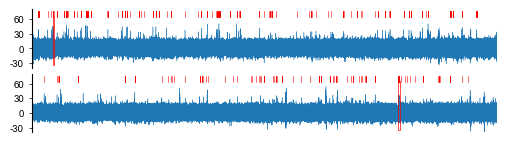

In [17]:
CHUNK = np.round(len(dff)/2).astype('int')
zoom_in_region = [
    (40500, 43000),
    #(859500, 862000),
    (1609500, 1612000),
]  # for mouse M984L FOVXa 20230717
zoom_in_region = [(zr[0]-CHUNK*i, zr[1]-CHUNK*i) for i, zr in enumerate(zoom_in_region)]

rect = [patches.Rectangle((zr[0], -0.35), zr[1]-zr[0]+500,  1.0, linewidth=0.5, edgecolor='red', fill=False, zorder=2) for zr in zoom_in_region]
fig = plt.figure(figsize=(6, 1.6))
plt.rcParams['font.size'] = '7'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
gs1 = gridspec.GridSpec(2, 1)
gs1.update(wspace=0., hspace=0.1)
axes = [plt.subplot(gs1[i, 0]) for i in range(2)]
for i, ax in enumerate(axes):
    #ax.axis('off')  
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.tick_params(axis='y', which='major', direction='out',length=2, width=0.5)
    ax.set_yticks(np.linspace(-0.3, 0.6, 4), (np.linspace(-0.3, 0.6, 4)*100).astype('int'))
for i in range(2):
    spt = np.where(np.logical_and(APs>i*CHUNK, APs<(i+1)*CHUNK))[0]
    axes[i].plot(-dff[i*CHUNK:(i+1)*CHUNK], linewidth=0.3)
    #axes[i].plot(APs[spt]-i*CHUNK, 0.7 * np.ones(spt.shape), color='red', marker='|', fillstyle='none', linestyle='none', markersize=10)
    AP_ticks(axes[i], APs[spt]-i*CHUNK, tick_level=0.7, tick_height=0.12, linewidth=0.4)
    axes[i].set_ylim([-0.4, 0.8])
    axes[i].set_xlim([0, CHUNK])
    roi_box = rect[i]
    axes[i].add_patch(rect[i])
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
#plt.savefig(os.path.join(working_dir, 'full_trace_2308_binned.pdf'), bbox_inches='tight')

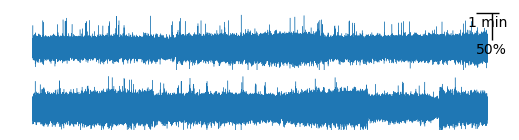

In [144]:
fig = plt.figure(figsize=(5, 1.2))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(wspace=0., hspace=0.)
axes = [plt.subplot(gs1[i, 0]) for i in range(2)]
scalebar_hr = AnchoredSizeBar(axes[0].transData,
                        500*60, '1 min', 1, 
                        pad=0.1,
                        color='k',
                        frameon=False,
                        size_vertical=0)

scalebar_vt = AnchoredSizeBar(axes[0].transData,
                        0, '50%', 1, 
                        pad=0.1,
                        color='k',
                        frameon=False,
                        size_vertical=0.5)
axes[0].add_artist(scalebar_hr)
axes[0].add_artist(scalebar_vt)

for i, ax in enumerate(axes):
    ax.axis('off')  
for i in range(2):
    spt = np.where(np.logical_and(APs>i*CHUNK, APs<(i+1)*CHUNK))[0]
    axes[i].plot(-dff[i*CHUNK:(i+1)*CHUNK], linewidth=0.3)
    axes[i].set_ylim([-0.4, 0.7])
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'full_trace.png'), dpi=300)

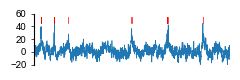

In [6]:
fig = plt.figure(figsize=(2.2, 0.6))
plt.rcParams['font.size'] = '7'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
ax = fig.add_subplot(111)  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='y', which='major', direction='out',length=2, width=0.5)
ax.set_yticks(np.linspace(-20, 60, 5))

ax.plot(-dff*100, linewidth=0.5)
AP_ticks(ax, APs, tick_level=50, tick_height=10, linewidth=0.5)
ax.set_ylim([-20, 60])
ax.set_xlim([40500, 43000])
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'trace_begin.pdf'))

In [12]:
zoom_trace = dff[40500:43000].flatten()
zoom_APs = APs[np.logical_and(APs>=40500, APs<43000)] - 40500 
spike_SNR(zoom_trace, zoom_APs)

-8.723922328544797

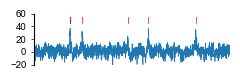

In [13]:
fig = plt.figure(figsize=(2.2, 0.6))
plt.rcParams['font.size'] = '7'
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
ax = fig.add_subplot(111)  
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.tick_params(axis='y', which='major', direction='out',length=2, width=0.5)
ax.set_yticks(np.linspace(-20, 60, 5))

ax.plot(-dff*100, linewidth=0.5)
AP_ticks(ax, APs, tick_level=50, tick_height=10, linewidth=0.5)
ax.set_ylim([-20, 60])
ax.set_xlim([1609500, 1612000])
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'trace_end.pdf'))

In [14]:
zoom_trace = dff[1609500:1612000].flatten()
zoom_APs = APs[np.logical_and(APs>1609500, APs<1612000)] - 1609500 
spike_SNR(zoom_trace, zoom_APs)

-7.25816055346125

## old figures

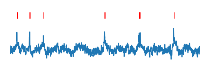

In [14]:
fig = plt.figure(figsize=(1.9, 0.6))
#plt.plot(-dff[5000:10000],color='midnightblue', linewidth=0.5) # for moco 
plt.plot(-dff,linewidth=0.5) # for moco_aff_crop
AP_ticks(plt.gca(), APs, tick_level=0.7, tick_height=0.12, linewidth=0.4)
plt.ylim([-0.4, 0.8])
plt.xlim([40500, 43000])
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'trace_begin.pdf'))

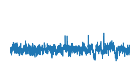

In [13]:
fig = plt.figure(figsize=(1.2, 0.6))
#plt.plot(-dff[5000:10000],color='midnightblue', linewidth=0.5) # for moco 
plt.plot(-dff,linewidth=0.5) # for moco_aff_crop
plt.ylim([-0.4, 0.8])
plt.xlim([859500, 862000])
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'trace_middle.pdf'))

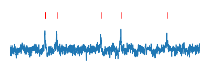

In [15]:
fig = plt.figure(figsize=(1.9, 0.6))
#plt.plot(-dff[1609500:1612000],color='midnightblue', linewidth=0.5) # for moco 
plt.plot(-dff,linewidth=0.5) # for moco_aff_crop
AP_ticks(plt.gca(), APs, tick_level=0.7, tick_height=0.12, linewidth=0.4)
plt.ylim([-0.4, 0.8])
plt.xlim([1609500, 1612000])
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'trace_end.pdf'))

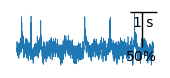

In [145]:
fig = plt.figure(figsize=(1.5, 0.6))
ax = plt.subplot(111)
scalebar_hr = AnchoredSizeBar(ax.transData,
                        500*1, '1 s', 1, 
                        pad=0.1,
                        color='k',
                        frameon=False,
                        size_vertical=0)

scalebar_vt = AnchoredSizeBar(ax.transData,
                        0, '50%', 1, 
                        pad=0.1,
                        color='k',
                        frameon=False,
                        size_vertical=0.5)

ax.add_artist(scalebar_hr)
ax.add_artist(scalebar_vt)
ax.plot(-dff[40500:43000],linewidth=0.5) # for moco_aff_crop
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
plt.savefig(os.path.join(working_dir, 'trace_begin_bar.png'))

## the other recording with more spikes

In [134]:
working_dir = '/Volumes/CLab/hour_long_recording/moco/volpy_results/'
mat_list = glob.glob(os.path.join(working_dir, '*dff_volpy.mat'))
mat_list.sort()
traces = []
baselines = []
SNR = []
APs = []
for idx, mf in enumerate(mat_list):
    # load mat file
    mdic = sio.loadmat(mf)
    dff = mdic['dff'].squeeze()
    spike_locs = mdic['spike_locs'].squeeze()
    f_trace = mdic['raw_trace'].squeeze() - mdic['bg'].squeeze()
    baseline = flatten(f_trace, 200)
    f_trace_flat = f_trace - baseline
    traces.append(f_trace)
    baselines.append(baseline)
    SNR.append(spike_SNR(-f_trace_flat, spike_locs))
    APs.append(spike_locs + idx * len(dff))

baselines = np.hstack(baselines)
traces = np.hstack(traces)
APs = np.hstack(APs)

baseline_filtered = signal_filter(baselines, 0.01, 500, order=1, mode='low')
dff = (traces - baselines) / baseline_filtered

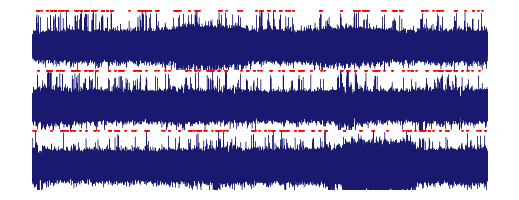

In [135]:
CHUNK = np.round(len(dff)/3).astype('int')
fig = plt.figure(figsize=(5, 1.8))
gs1 = gridspec.GridSpec(3, 1)
gs1.update(wspace=0., hspace=0.)
axes = [plt.subplot(gs1[i, 0]) for i in range(3)]
for i, ax in enumerate(axes):
    ax.axis('off')  
for i in range(3):
    spt = np.where(np.logical_and(APs>i*CHUNK, APs<(i+1)*CHUNK))[0]
    axes[i].plot(-dff[i*CHUNK:(i+1)*CHUNK], color='midnightblue', linewidth=0.3)
    axes[i].plot(APs[spt]-i*CHUNK, 0.6 * np.ones(spt.shape), color='r', marker='.', fillstyle='none', linestyle='none', markersize=2)
    axes[i].set_ylim([-0.4, 0.6])
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
#plt.savefig(os.path.join(working_dir, 'full_trace.pdf'))

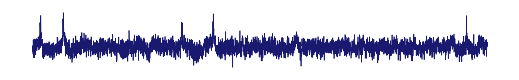

In [139]:
fig = plt.figure(figsize=(5, 0.6))
plt.plot(-dff[5000:10000],color='midnightblue', linewidth=0.5) # for moco 
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
#plt.savefig(os.path.join(working_dir, 'trace_begin.eps'))

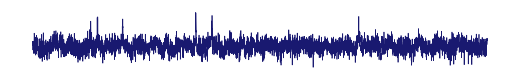

In [137]:
fig = plt.figure(figsize=(5, 0.6))
#plt.plot(-dff[CHUNK+17500:CHUNK+22500],color='midnightblue', linewidth=0.5)
plt.plot(-dff[CHUNK+17500:CHUNK+22500],color='midnightblue', linewidth=0.5)
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
#plt.savefig(os.path.join(working_dir, 'trace_middle.eps'))

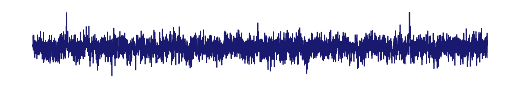

In [138]:
fig = plt.figure(figsize=(5, 0.7))
#plt.plot(-dff[-13000:-8000],color='midnightblue', linewidth=0.5)
plt.plot(-dff[-13000:-8000],color='midnightblue', linewidth=0.5)
plt.axis('off')
plt.tight_layout(pad=0, h_pad=None, w_pad=None)
#plt.savefig(os.path.join(working_dir, 'trace_end.eps'))